# Task 1

---

## 1.1. Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### 1.1.1. Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [34]:
import requests
import numpy as np
import pandas as pd
import re, nltk,gensim
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100
reviews = []
# for i in range(1, pages + 1):
for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    # Collect HTML data from this page
    response = requests.get(url)
    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    print(f"   ---> {len(reviews)} total reviews")

### 1.2. Analyse data
#### 1.2.1. Load and Preprocess Data:

In [2]:
df = pd.read_csv('BA_reviews_raw.csv',index_col='ID').reset_index(drop=True)
print("The Dataframe's shape is",df.shape)
df.head()

The Dataframe's shape is (1000, 1)


,reviews
0,✅ Trip Verified | This flight was one of the ...
1,Not Verified | It seems that there is a race t...
2,Not Verified | As a Spanish born individual l...
3,✅ Trip Verified | A rather empty and quiet fl...
4,✅ Trip Verified | Easy check in and staff mem...


Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [3]:
df['verified'] = df['reviews'].apply(lambda x: x.split('|')[0])
df['reviews'] = df['reviews'].apply(lambda x: x.split('|')[1])
verify_map = {'✅ Trip Verified ':'Verified','Not Verified ':'Not Verified'}
df['verified'] = df['verified'].map(verify_map)
df.head(2)

,reviews,verified
0,This flight was one of the worst I have ever...,Verified
1,It seems that there is a race to the bottom a...,Not Verified


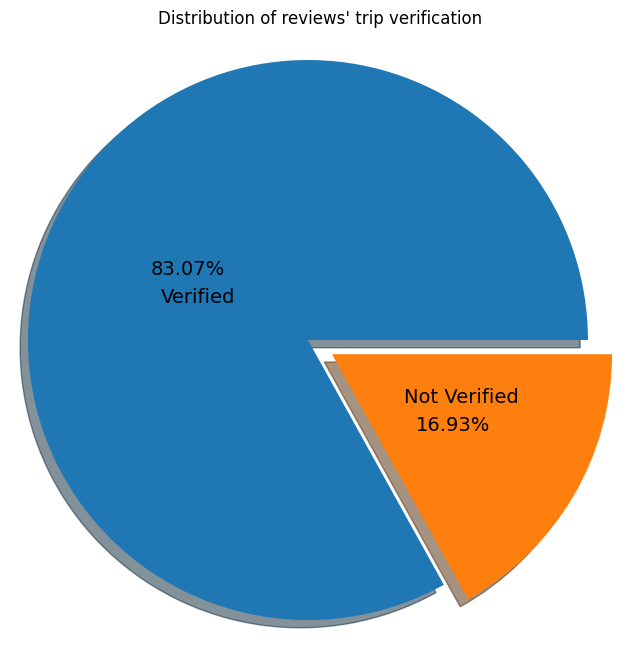

In [4]:
fig, ax = plt.subplots(figsize=(8,8))
plt.pie(x=df['verified'].value_counts(),explode=(0,0.1),labels=df['verified'].value_counts().index.to_list(),
        labeldistance=0.3,pctdistance=0.5,shadow=True,autopct='%1.2f%%',textprops={'fontsize': 14},radius=1)
ax.axis('equal')
plt.title("Distribution of reviews' trip verification")
plt.savefig('1.png', dpi=200, bbox_inches='tight')
plt.show()

In [43]:
def Text_preprocess(dataframe,targeted_col):
    X = []
    porter = nltk.stem.PorterStemmer()
    for i in range(len(dataframe)):
        s = dataframe[targeted_col][i]
        s = re.sub('[^a-zA-Z]',' ',s)
        s = s.lower()
        s = s.split()
        s = [word for word in s if word not in nltk.corpus.stopwords.words('english')]
        s = ' '.join(s)
        s = porter.stem(s)
        X.append(s)
    return X

In [6]:
processed_reviews = Text_preprocess(df,'reviews')
df['Proccesed_reviews'] = processed_reviews

In [61]:
def text_preprocess_frequency(s):
    s = re.sub('[^a-zA-Z]',' ',s)
    s = s.lower()
    s = s.split()
    s = [word for word in s if word not in nltk.corpus.stopwords.words('english')]
    return s

In [62]:
words_list = df['reviews'].apply(text_preprocess_frequency).sum()
words_freq = Counter(words_list)

In [65]:
words_freq = dict(sorted(words_freq.items(),key=lambda item:item[1],reverse=True))

In [69]:
top_30_freq = dict(list(words_freq.items())[:30])

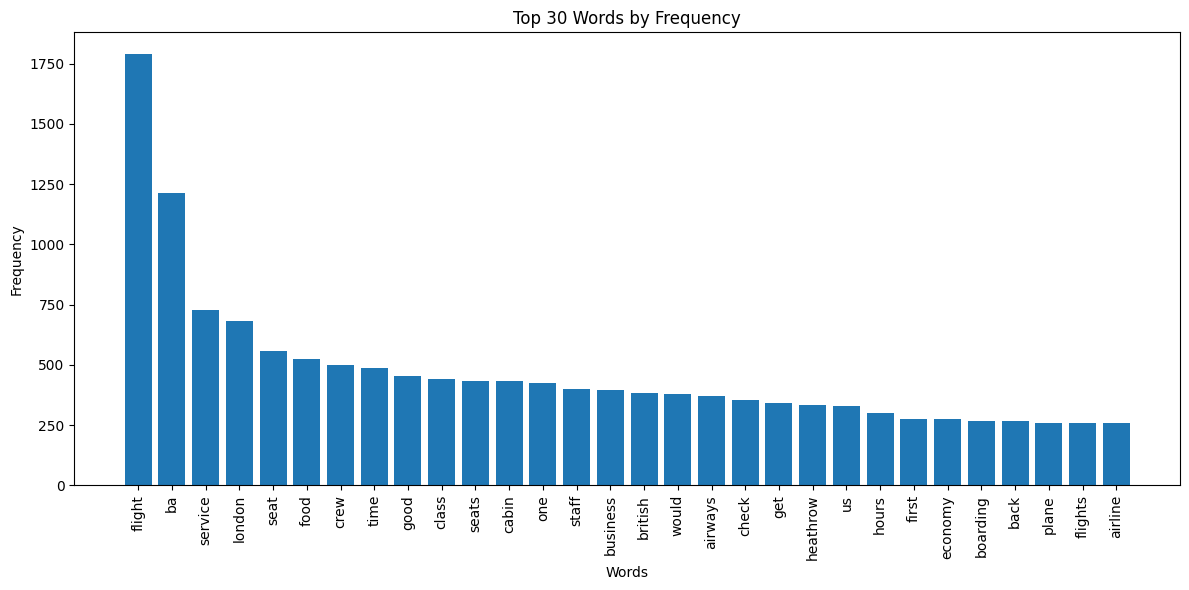

In [71]:
plt.figure(figsize=(12, 6))
plt.bar(top_30_freq.keys(), top_30_freq.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words by Frequency')
plt.xticks(rotation=90)
plt.tight_layout()  # To prevent label overlapping
plt.show()

#### 1.2.2. Sentiment Analysis:

In [7]:
def compoundpolarityscore(dataframe,targeted_col):
    Scores=[]
    SIA = SentimentIntensityAnalyzer()
    for i in range(len(dataframe)):
        s = dataframe[targeted_col][i]
        Scores.append(SIA.polarity_scores(s)['compound'])
    return Scores

In [8]:
df['Sentiment_Score'] = compoundpolarityscore(df,'Proccesed_reviews')

In [9]:
def Sentiment_desc(score):
    if score >= 0.5:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [10]:
df['Sentiment_Description'] = df['Sentiment_Score'].apply(Sentiment_desc)
df.head(3)

,reviews,verified,Proccesed_reviews,Sentiment_Score,Sentiment_Description
0,This flight was one of the worst I have ever...,Verified,flight one worst ever life wanted pamper bough...,-0.9313,Negative
1,It seems that there is a race to the bottom a...,Not Verified,seems race bottom amongst airlines cannot even...,-0.8402,Negative
2,As a Spanish born individual living in Engla...,Not Verified,spanish born individual living england using b...,0.8459,Positive


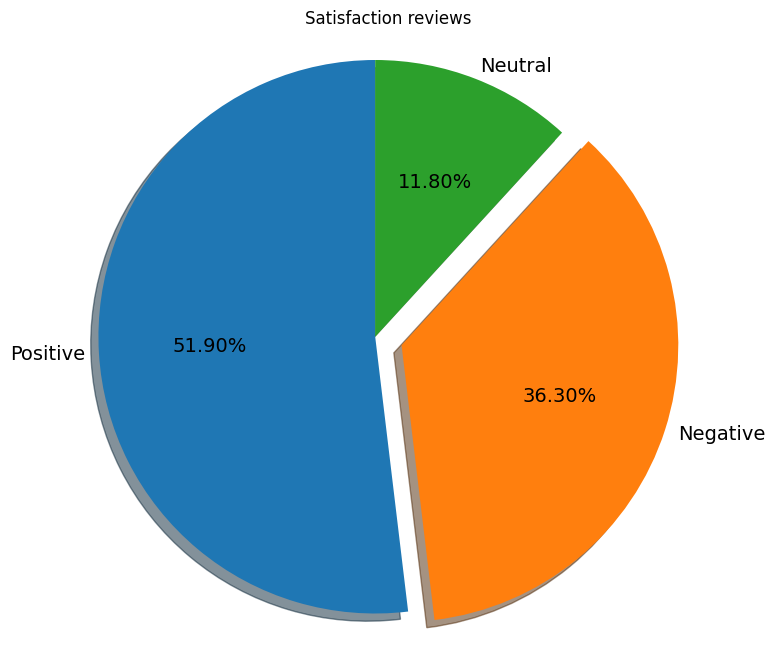

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
plt.pie(x=df['Sentiment_Description'].value_counts(),explode=(0,0.1,0),labels=df['Sentiment_Description'].value_counts().index.to_list(),
        labeldistance=1.05,pctdistance=0.6,shadow=True,autopct='%1.2f%%',textprops={'fontsize': 14},radius=1,startangle=90)
ax.axis('equal')
plt.title("Satisfaction reviews")
plt.savefig('2.png', dpi=200, bbox_inches='tight')
plt.show()

#### 1.2.3. Topic Modelling:

In [12]:
text_vect = CountVectorizer(lowercase=True,stop_words='english',min_df=10)
X = text_vect.fit_transform(processed_reviews)

In [13]:
LDAM = LatentDirichletAllocation(n_components=5,learning_method='online',max_iter=20,n_jobs=-1,random_state=1024)
LDAM.fit_transform(X)

array([[0.49143531, 0.38977904, 0.00284193, 0.0028456 , 0.11309811],
       [0.93538699, 0.04397638, 0.00679536, 0.00693727, 0.006904  ],
       [0.00233182, 0.00230136, 0.00229956, 0.99074589, 0.00232137],
       ...,
       [0.00251916, 0.98984579, 0.00250594, 0.0025439 , 0.00258521],
       [0.09285117, 0.43189137, 0.43546721, 0.00413747, 0.03565278],
       [0.16501783, 0.82465347, 0.0034143 , 0.00342067, 0.00349372]])

In [14]:
Review_Topics = pd.DataFrame(data=LDAM.fit_transform(X).round(2),columns=[x for x in ['Topic_' + str(i+1) for i in range(LDAM.n_components)]])
Review_Topics['Main_Topic'] = np.argmax(Review_Topics.values,axis=1) + 1
Review_Topics.head()

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Main_Topic
0,0.49,0.39,0.00,0.00,0.11,1
1,0.94,0.04,0.01,0.01,0.01,1
2,0.00,0.00,0.00,0.99,0.00,4
3,0.23,0.01,0.63,0.01,0.12,3
4,0.00,0.00,0.98,0.00,0.00,3


In [15]:
df['Main_Topic'] = Review_Topics['Main_Topic'].to_list()
df.head()

,reviews,verified,Proccesed_reviews,Sentiment_Score,Sentiment_Description,Main_Topic
0,This flight was one of the worst I have ever...,Verified,flight one worst ever life wanted pamper bough...,-0.9313,Negative,1
1,It seems that there is a race to the bottom a...,Not Verified,seems race bottom amongst airlines cannot even...,-0.8402,Negative,1
2,As a Spanish born individual living in Engla...,Not Verified,spanish born individual living england using b...,0.8459,Positive,4
3,"A rather empty and quiet flight to Tel Aviv,...",Verified,rather empty quiet flight tel aviv friendly ca...,0.2960,Neutral,3
4,Easy check in and staff member was polite an...,Verified,easy check staff member polite helpful made sp...,0.9732,Positive,3


In [16]:
def barchart_stacked_perc(df,x,hue,figsize_,title_,rot_,xlabel_,ylabel_,legend_fontsize,annot_fontsize,xticklabels=None,savename_='barchart_stacked_perc.png'):
    plot_data = df.groupby(x)[hue].value_counts(normalize=True).mul(100).rename('perc').reset_index()
    plot_data = plot_data.pivot(columns=hue,index=x,values='perc').fillna(0)
    ax = plot_data.plot(kind='bar',figsize=figsize_,rot=rot_,stacked=True,edgecolor='k')
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
        x,y = p.get_xy()
        if height >= 0.1:
                plt.annotate(f'{height.round(1)}%',xy=(x + width/2, y + height/2),ha='center',va='center',size=annot_fontsize)
    plt.legend(['Negative','Neutral','Positive'],loc='best',fontsize=legend_fontsize)
    modified_xlabel = x.astype(str)
    plt.xlabel(xlabel_)
    plt.ylabel(ylabel_)
    plt.title(title_)
    if xticklabels:
        ax.set_xticks(range(len(xticklabels)))
        ax.set_xticklabels(xticklabels)
    plt.savefig(savename_, dpi=200, bbox_inches='tight')
    plt.show()

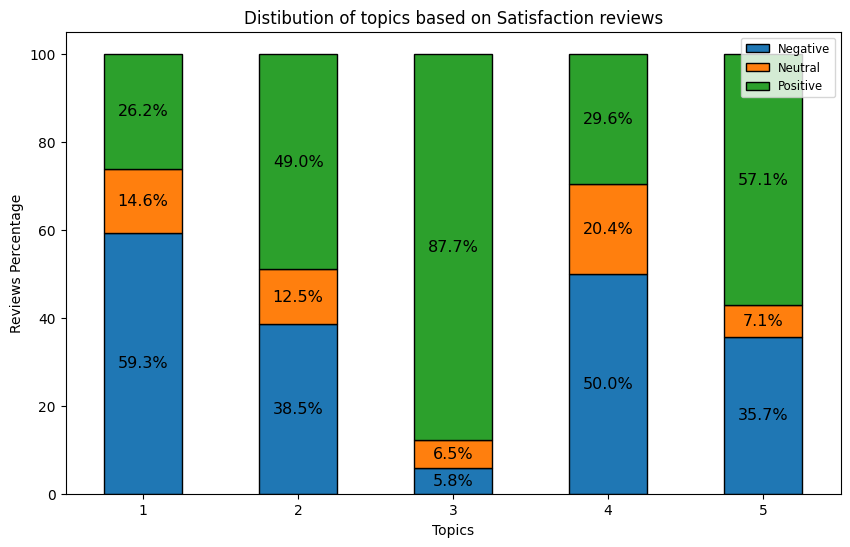

In [17]:
barchart_stacked_perc(df,'Main_Topic','Sentiment_Description',(10,6),'Distibution of topics based on Satisfaction reviews',
                      0,'Topics','Reviews Percentage','small',11.5,xticklabels=None)

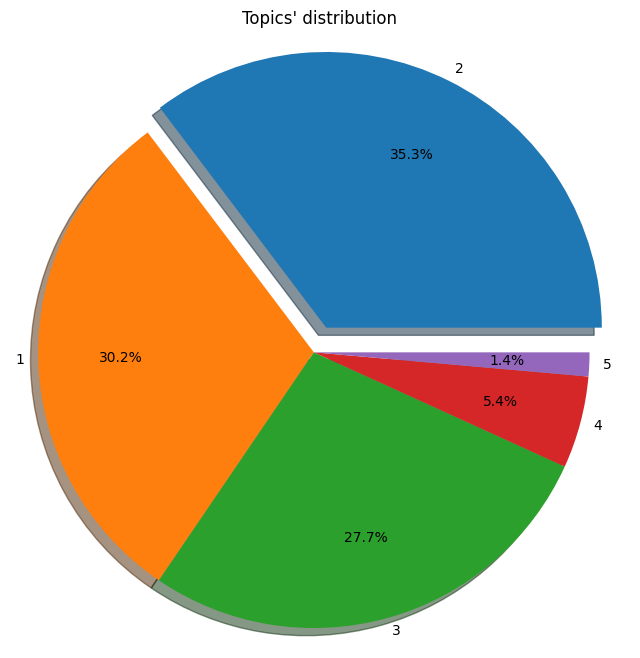

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
plt.pie(x=df['Main_Topic'].value_counts(),explode=(0.1,0,0,0,0),labels=df['Main_Topic'].value_counts().index.to_list(),
        labeldistance=1.05,pctdistance=0.7,shadow=True,autopct='%1.1f%%',textprops={'fontsize': 10},radius=1,startangle=0)
ax.axis('equal')
plt.title("Topics' distribution")
plt.savefig('7.png', dpi=200, bbox_inches='tight')
plt.show()

#### 1.2.4. Word Clouds:

##### 1.2.4.1 Word clouds of postive reviews:

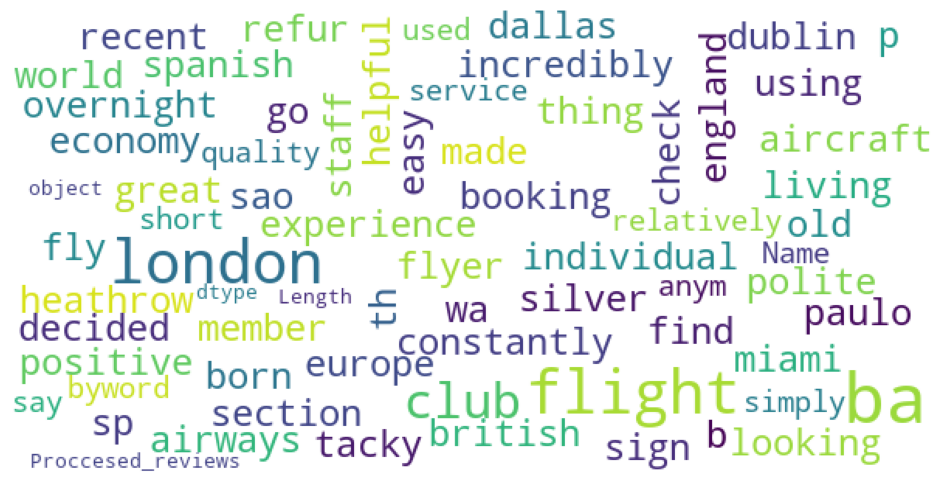

In [18]:
WC = WordCloud(width=600,height=300,background_color='white',stopwords=set(STOPWORDS),max_font_size=45,max_words=75,random_state=1024)
POS_WC = WC.generate(str(df.loc[df['Sentiment_Description'] =='Positive','Proccesed_reviews']))
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(POS_WC)
plt.savefig('4.png', dpi=200, bbox_inches='tight')
plt.show()

##### 1.2.4.2 Word clouds of Negative reviews:

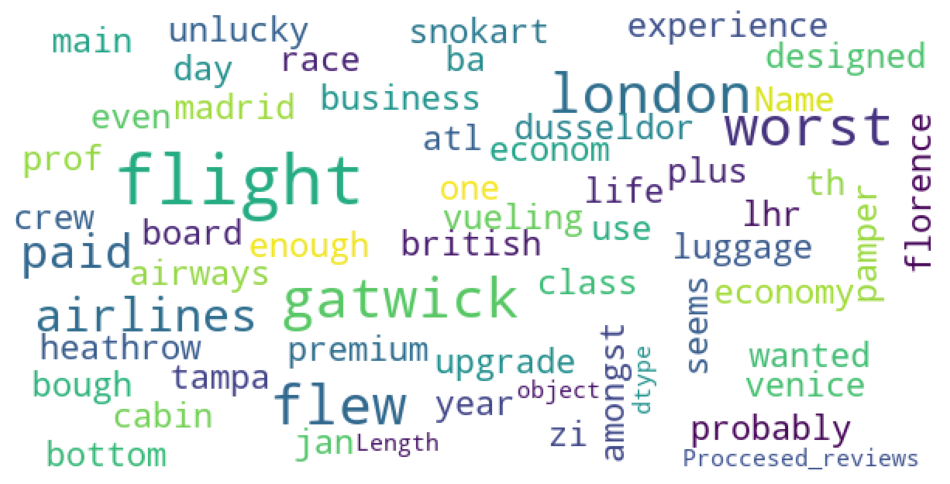

In [19]:
NEG_WC = WC.generate(str(df.loc[df['Sentiment_Description'] =='Negative','Proccesed_reviews']))
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(NEG_WC)
plt.savefig('5.png', dpi=200, bbox_inches='tight')
plt.show()

##### 1.2.4.3 Word clouds of Neutral reviews:

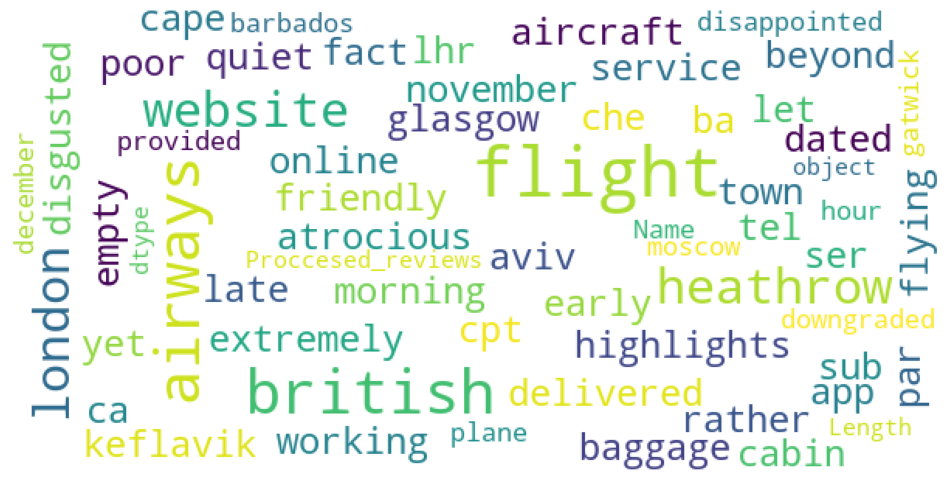

In [20]:
Neutral_WC = WC.generate(str(df.loc[df['Sentiment_Description'] =='Neutral','Proccesed_reviews']))
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(Neutral_WC)
plt.savefig('6.png', dpi=200, bbox_inches='tight')
plt.show()